In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch 
import os 
import pandas as pd

In [3]:
torch.cuda.is_available()

True

In [200]:
img_path = 'public_tests/00_test_img_input/train/images/'
labels_path = 'public_tests/00_test_img_input/train/gt.csv'

In [8]:
imgs = os.listdir(img_path)

In [9]:
labels_df = pd.read_csv(labels_path)

In [10]:
labels_df.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,00000.jpg,51,51,127,60,169,65,203,52,68,...,193,84,156,144,92,174,140,180,168,179
1,00001.jpg,21,20,36,18,57,19,80,25,23,...,78,33,43,46,31,61,45,66,60,65
2,00002.jpg,23,116,39,83,47,57,56,19,36,...,62,31,91,86,106,122,115,100,121,81
3,00003.jpg,29,18,63,25,84,32,105,34,38,...,95,45,72,71,46,83,63,87,75,89
4,00004.jpg,31,53,76,44,107,38,136,33,40,...,129,49,111,105,72,137,106,132,126,121


In [403]:
def extract_data():
    items = []
    print(len(imgs))
    for i in range(len(imgs)):
        # img = imgs[i]
        labels = labels_df.loc[labels_df['filename'] == imgs[i]][labels_df.columns[1:]].values
        labels = torch.from_numpy(labels)
        items.append((os.path.join(img_path, imgs[i]), labels[0]))
        # print(items[:5])

    # items = []
    # for i in range(labels_df.shape[0]):
    #     columns = labels_df.columns
    #     filename = labels_df[columns[0]][i]
    #     labels = labels_df[labels_df.columns[2:]].values
    #     items.append((os.path.join(img_path, filename), labels[0]))

    y = labels_df.loc[labels_df['filename'] == imgs[0]][labels_df.columns[1:]]
    return items

In [250]:
new_df = pd.DataFrame(columns=labels_df.columns)
new_df

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14


In [263]:
new_df.loc[len(new_df)] = labels_df.loc[0]
new_df

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,00000.jpg,51,51,127,60,169,65,203,52,68,...,193,84,156,144,92,174,140,180,168,179
1,00000.jpg,51,51,127,60,169,65,203,52,68,...,193,84,156,144,92,174,140,180,168,179


In [262]:
# pd.concat([pd.DataFrame(labels_df.loc[0].values), new_df.loc[:]])#.reset_index(drop=True)

In [344]:
import matplotlib.pyplot as plt
from PIL import Image
import detection

In [345]:
def vizualize(img, keypoints, transpose = True, to_torch = False):
    if to_torch:
        img = torch.from_numpy(img)
    if transpose:
        img = img.permute(1, 2, 0)
    plt.imshow(img.int())
    for i in range(0, len(keypoints)-1, 2):
        x = keypoints[i]
        y = keypoints[i+1]
        plt.plot(x,y, 'og', markersize=6)
    plt.show()

In [346]:
test_imgs_dir = 'public_tests/splitted/test/images/'
test_gt_path = 'public_tests/splitted/test/gt.csv'

In [347]:
facesPointsDataset = detection.FacesPointsDataset(imgs_path=test_imgs_dir, labels_path=test_gt_path, mode='val')

In [348]:
# model = detection.FacesPointsDetector()
# device = torch.device('cpu')
# model.load_state_dict(torch.load('lightning_logs/version_17/checkpoints/epoch=15-step=4800.ckpt', map_location=device))

In [349]:
chkpt_path =  'lightning_logs/version_25/checkpoints/epoch=7-step=2408.ckpt' #'lightning_logs/version_24/checkpoints/epoch=7-step=2408.ckpt' # 'lightning_logs/version_20/checkpoints/epoch=7-step=2408.ckpt' #lightning_logs/version_17/checkpoints/epoch=15-step=4800.ckpt'

In [350]:
module =  detection.FacesPointsTrainingModule.load_from_checkpoint(chkpt_path, map_location='cpu')

d:\venvs\CV\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [361]:
img, label = facesPointsDataset[3]

In [362]:
# module.eval()

In [363]:
# module.to('cpu')
predict = module(img[None,:]).detach()[0]

In [364]:
print(predict)
print(label)

tensor([ 8.6377, 38.7561, 26.0854, 31.6778, 53.4980, 21.1864, 69.8604,  9.6933,
        17.2543, 47.8499, 25.5774, 43.4903, 31.2889, 41.7366, 57.9028, 30.7179,
        65.0860, 26.6035, 70.3151, 23.2493, 59.2949, 57.5620, 48.6113, 76.1953,
        64.4912, 72.6658, 77.5608, 63.3661])
tensor([ 7, 40, 31, 31, 42, 25, 63,  9, 15, 47, 25, 42, 31, 40, 50, 29, 58, 23,
        64, 19, 54, 54, 40, 69, 59, 66, 70, 50])


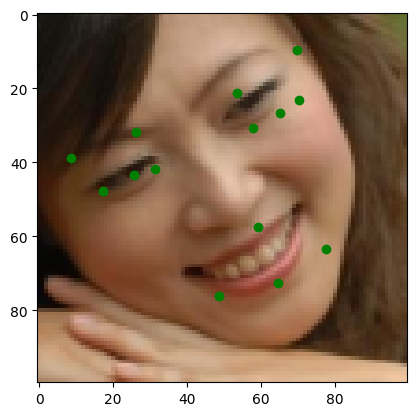

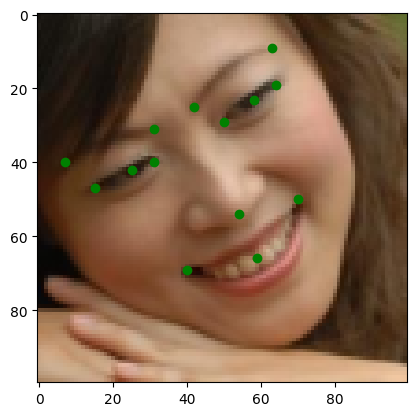

In [365]:
vizualize(img, predict)
vizualize(img, label)

In [196]:
import shutil

In [240]:
# permutation = np.random.permutation(6000)
permutation

array([5794,  778, 5596, ..., 1264,  998, 2015])

In [268]:
def train_valid_split(imgs_path, fraction, new_test_path, new_train_path, gt_train_path, gt_test_path, permutation = None):
    imgs = os.listdir(imgs_path)
    labels_df = pd.read_csv(labels_path)
    
    test_df = pd.DataFrame(columns=labels_df.columns)
    train_df = pd.DataFrame(columns=labels_df.columns)

    imgs_count = len(imgs)

    if permutation is None:
        permutation = np.random.permutation(imgs_count)
        print(permutation)

    train_items = []
    test_items = []
    for i in range(imgs_count):
        img_idx = permutation[i]
        labels = labels_df.loc[img_idx]
        assert(labels['filename'] == imgs[img_idx])
        # print(labels.columns)
        # print(labels_df.columns)
        img_path = os.path.join(imgs_path, imgs[img_idx])
        if i <= fraction*imgs_count:
            # train_df.append(labels)
            # train_df = pd.concat([train_df, pd.DataFrame(labels.values)], ignore_index=True)
            # train_df.loc[len(train_df)] = labels
            train_df.loc[len(train_df)] = labels #labels_df.loc[0]
            shutil.copy(img_path, new_train_path)
        else:
            test_df.loc[len(test_df)] = labels #test_df = pd.concat([test_df, pd.DataFrame(labels.values)], ignore_index=True)
            shutil.copy(img_path, new_test_path)
        
    test_df.to_csv(os.path.join(gt_test_path, 'gt_test.csv'), index=False)
    train_df.to_csv(os.path.join(gt_train_path, 'gt_train.csv'), index=False)
        

In [270]:
# train_valid_split(img_path, fraction=0.8, new_test_path='public_tests/splitted/test/',
#  new_train_path='public_tests/splitted/train/', gt_test_path='public_tests/splitted/', gt_train_path='public_tests/splitted/', permutation = permutation)

In [366]:
import albumentations as A

In [397]:
MyTransform = A.Compose(
    [
        # A.RandomResizedCrop(width=128, height=128, p=0.3),
        A.Rotate(limit=30),
        A.HorizontalFlip(p=0.3),
        # A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    ], 
    keypoint_params = A.KeypointParams(format = 'xy') 
)

In [404]:
items = extract_data()

6000


In [400]:
# dataset_with_aug = detection.FacesPointsDataset(test_imgs_dir, test_gt_path, mode='test', transform=MyTransform)

In [412]:
def get_img(filename):
    # path = os.path.join(img_path, filename)
    ## read image
    image = Image.open(filename).convert("RGB")
    image = np.array(image).astype(np.float32)
    
    return image

In [414]:
for i in range(3):
    filename,label = items[i]
    image = get_img(filename)
    vizualize(image, label, False)

AttributeError: 'numpy.ndarray' object has no attribute 'int'